In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Import libraries

In [2]:
import os

from PIL import Image
import cv2

import matplotlib.pyplot as plt

import numpy as np 
from numpy import asarray

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split

# 2. Pre-process Data

In [3]:
def LoadData(path1):
   """
   Load paired image and mask filenames from a directory.

   Args:
       path1 (str): Directory path containing .tif images and masks

   Returns:
       tuple: Lists of image filenames and corresponding mask filenames
   """
   # Get sorted list of files in directory  
   data = os.listdir(path1)
   img = []
   mask_img = []
   data.sort()
   
   # Extract paired image and mask filenames
   for file in data:
       if file.endswith('_mask.tif'):
           mask_img.append(file)
           img.append(file.replace("_mask.tif",".tif"))       
   
   return img, mask_img

In [4]:
# Initialize the file path and load the data
file_path = "/kaggle/input/ultrasound-nerve-segmentation/train/"
img, mask_img = LoadData(file_path)

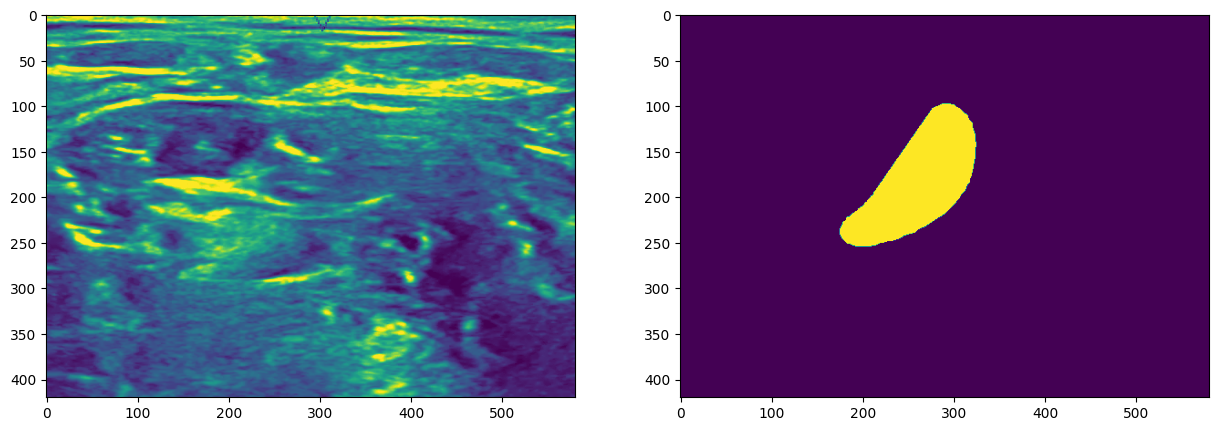

In [5]:
img_path = file_path + img[0]
view_path = file_path + mask_img[0]
img_view = Image.open(img_path)
mask_view = Image.open(view_path)

fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_view)
arr[1].imshow(mask_view)
plt.show()

In [6]:
def preprocess_data(img, mask, path1):
   """
   Preprocess paired image and mask files into normalized numpy arrays.
   
   Args:
       img (list): List of image filenames 
       mask (list): List of mask filenames
       path1 (str): Directory path containing the files
       
   Returns:
       tuple: Arrays of preprocessed images and masks, normalized to [0,1]
   """
   # Initialize arrays for images and masks
   X = np.zeros((len(img), 128, 128, 3))
   y = np.zeros((len(mask), 128, 128, 1))
   
   # Process each image-mask pair
   for index, (img_file, mask_file) in enumerate(zip(img, mask)):
       # Load and preprocess image
       img_path = os.path.join(path1, img_file)
       image = Image.open(img_path).convert('RGB')
       image = image.resize((128,128))
       image = np.reshape(image,(128,128,3)) 
       image = image/256
       X[index] = image
       
       # Load and preprocess mask
       mask_path = os.path.join(path1, mask_file)
       mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
       mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
       mask = asarray(mask)
       mask = mask[..., tf.newaxis]
       mask = np.reshape(mask,(128,128,1)) 
       mask = mask / 255
       y[index] = mask.astype(int)
       
   return X,y

In [7]:
X,y = preprocess_data(img, mask_img, file_path)

Text(0.5, 1.0, 'Processed Masked Image ')

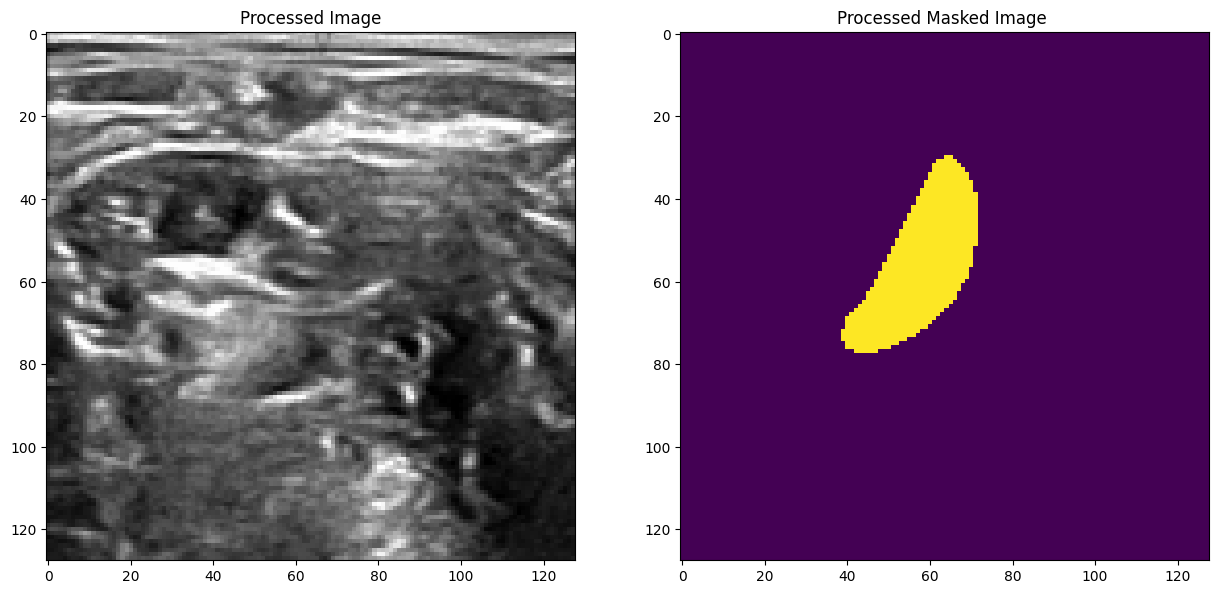

In [8]:
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index])
arr[1].set_title('Processed Masked Image ')

# 3. Unet Modeling

In [18]:
def encoder_mini_block(inputs, n_filters, max_pooling=True):
   """
   Create an encoder block for U-Net with double convolution and optional pooling.
   
   Args:
       inputs: Input tensor
       n_filters (int): Number of filters for convolution layers
       max_pooling (bool): Whether to apply max pooling
       
   Returns:
       tuple: Next layer and skip connection tensors
   """
   # Double convolution with batch normalization
   conv = Conv2D(n_filters, 3, activation='relu', padding='same')(inputs)
   conv = Conv2D(n_filters, 3, activation='relu', padding='same')(conv)
   conv = BatchNormalization()(conv)
   
   # Apply max pooling if specified
   if max_pooling:
       next_layer = MaxPooling2D(pool_size=(2,2))(conv)
   else:
       next_layer = conv
       
   skip_connection = conv
   
   return next_layer, skip_connection

def decoder_mini_block(prev_input, skip_input, n_filters):
   """
   Create a decoder block for U-Net with upsampling and concatenation.
   
   Args:
       prev_input: Previous layer tensor
       skip_input: Skip connection tensor from encoder
       n_filters (int): Number of filters for convolution layers
       
   Returns:
       tensor: Output tensor after upsampling and convolutions
   """
   # Upsample and concatenate with skip connection
   conv = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same')(prev_input)
   conv = concatenate([conv, skip_input], axis=3)
   
   # Double convolution
   conv = Conv2D(n_filters, 3, activation='relu', padding='same')(conv)
   conv = Conv2D(n_filters, 3, activation='relu', padding='same')(conv)
   return conv

In [19]:
def model(input_size=(128, 128, 3), n_filters=32, n_classes=2):
   """
   Create U-Net model for image segmentation.
   
   Args:
       input_size (tuple): Input image dimensions (height, width, channels)
       n_filters (int): Base number of filters, doubled in each encoder block
       n_classes (int): Number of output classes
       
   Returns:
       model: Keras U-Net model
   """
   # Input layer
   inputs = Input(input_size)
   
   # Encoder path
   conv1, skip1 = encoder_mini_block(inputs, n_filters, max_pooling=True) 
   conv2, skip2 = encoder_mini_block(conv1, n_filters*2, max_pooling=True)
   conv3, skip3 = encoder_mini_block(conv2, n_filters*4, max_pooling=True)
   conv4, skip4 = encoder_mini_block(conv3, n_filters*8, max_pooling=True)
   conv5, skip5 = encoder_mini_block(conv4, n_filters*16, max_pooling=False)
   
   # Decoder path
   conv6 = decoder_mini_block(conv5, skip4, n_filters*8)
   conv7 = decoder_mini_block(conv6, skip3, n_filters*4)
   conv8 = decoder_mini_block(conv7, skip2, n_filters*2)
   conv9 = decoder_mini_block(conv8, skip1, n_filters)
   
   # Output layers
   conv9 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv9)
   outputs = Conv2D(n_classes, 1, padding='same')(conv9)
   
   model = tf.keras.Model(inputs=inputs, outputs=outputs)
   return model

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
unet = model(input_size=(128,128,3), n_filters=32, n_classes=2)
unet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_40[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_44[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_46[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 8, 8, 256) │          0 │ batch_normalizat

 Total params: 8,643,746 (32.97 MB)

 Trainable params: 8,641,762 (32.97 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [29]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


W0000 00:00:1733362432.752554      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9949 - loss: 0.0124

W0000 00:00:1733362458.470175      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9949 - loss: 0.0124

W0000 00:00:1733362462.597882     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733362464.727828      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - accuracy: 0.9949 - loss: 0.0124 - val_accuracy: 0.9917 - val_loss: 0.0301
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.9955 - loss: 0.0108 - val_accuracy: 0.9917 - val_loss: 0.0266
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9953 - loss: 0.0115 - val_accuracy: 0.9916 - val_loss: 0.0301
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.9957 - loss: 0.0101 - val_accuracy: 0.9917 - val_loss: 0.0320
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.9956 - loss: 0.0101 - val_accuracy: 0.9918 - val_loss: 0.0337
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 196ms/step - accuracy: 0.9960 - loss: 0.0093 - val_accuracy: 0.9913 - val_loss: 0.0319
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.9956 - loss: 0.0104 - val_accuracy: 0.9917 - val_loss: 0.0282
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.9958 - loss: 0.0100 - val

# 4. Predictions

In [30]:
def prepare_single_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 256
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_mask(model, image):
    pred = model.predict(image)
    mask = tf.argmax(pred[0], axis=-1)
    return mask

In [31]:
test_path = "/kaggle/input/ultrasound-nerve-segmentation/test/"
test_img = []
for file in os.listdir(test_path):
    test_img.append(file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


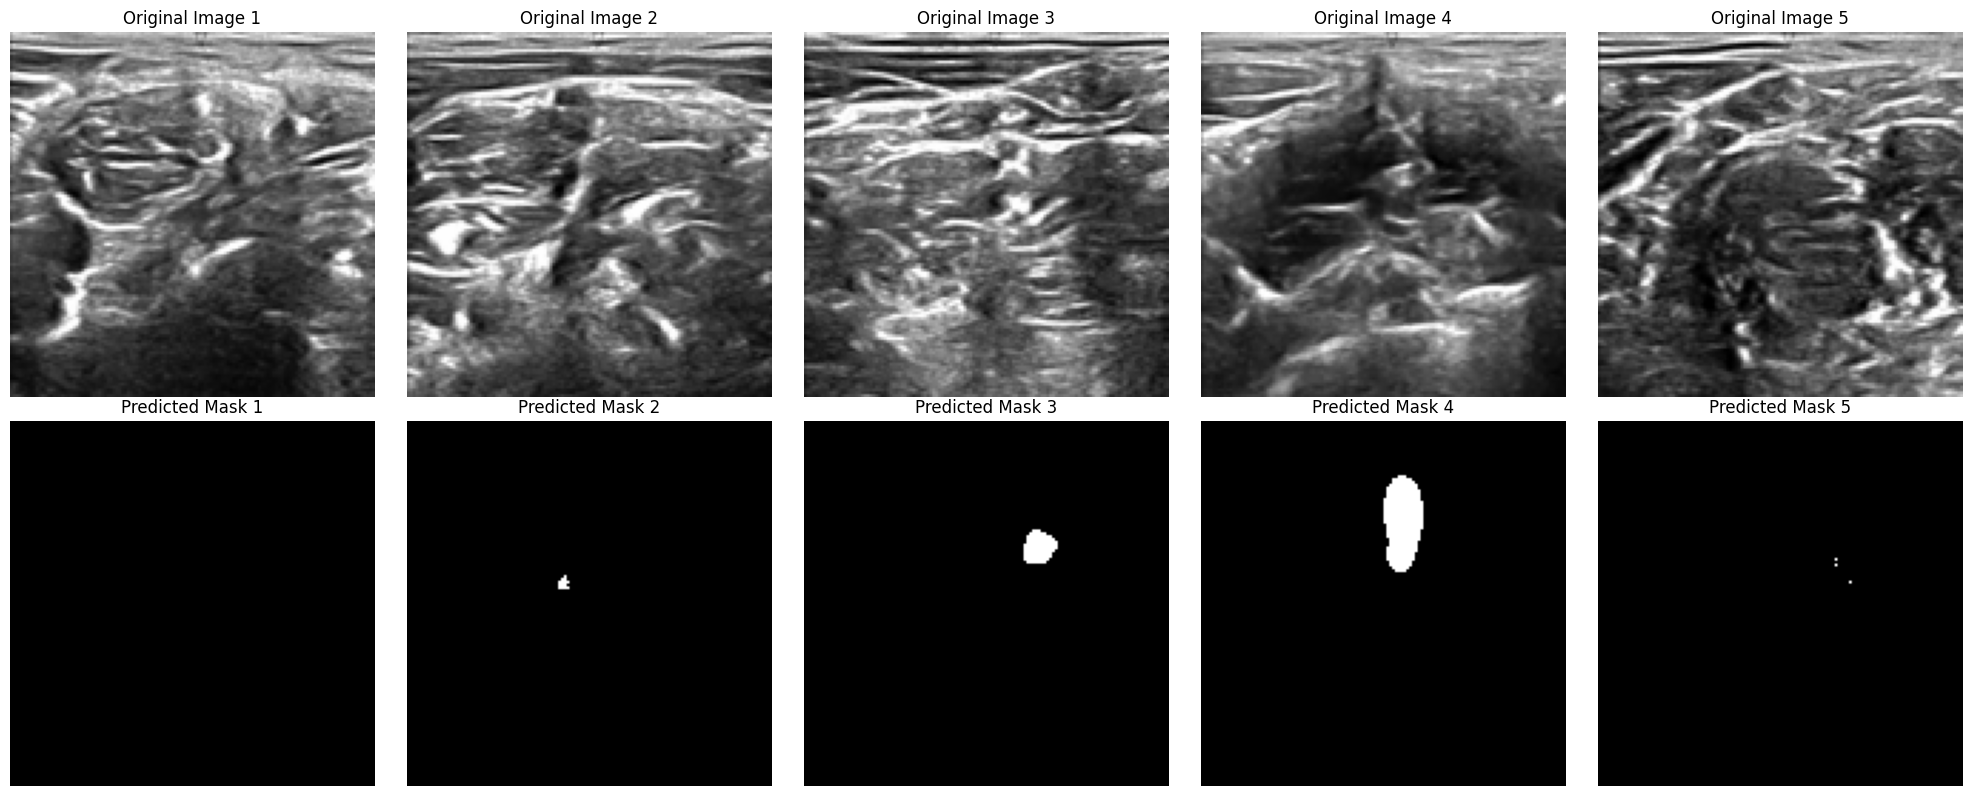

In [34]:
plt.figure(figsize=(20, 8))
for i in range(5):
   image_path = os.path.join(test_path, test_img[i])
   
   test_image = prepare_single_image(image_path)
   predicted_mask = predict_mask(unet, test_image)
   
   plt.subplot(2, 5, i+1)
   plt.imshow(test_image[0])
   plt.title(f'Original Image {i+1}')
   plt.axis('off')
   
   plt.subplot(2, 5, i+6)
   plt.imshow(predicted_mask, cmap='gray')
   plt.title(f'Predicted Mask {i+1}')
   plt.axis('off')

plt.tight_layout()
plt.show()